In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
import tensorflow as tf

Welcome to JupyROOT 6.10/08


In [2]:
p=0.3 #0.3-10GeV
mass=0.139

In [3]:
n_particles = 10000/2
p = np.random.uniform(0.3,10.,n_particles)
mp = np.random.uniform(1/10.,1/0.3,n_particles)
p_mp = 1./mp # viele Werte größer 10???

In [4]:
np.mean(p_mp)

1.0814965650760053

[]

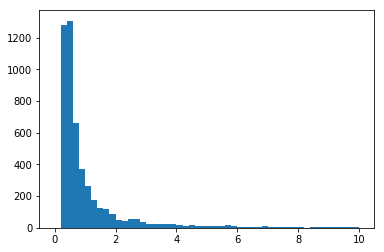

In [5]:
plt.hist(p_mp,50,range=(0.,10.))
plt.plot()

In [6]:
p_ges = np.concatenate([p,p_mp])

[]

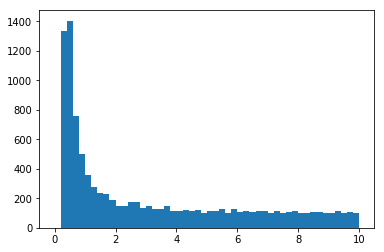

In [7]:
plt.hist(p_ges,50,range=(0,10))
plt.plot()

In [8]:
mass_pi = 0.139
mass_mu = 0.105
mass_e = 0.000511
mass_p = 0.938
mass_K = 0.494
masses = [mass_pi, mass_mu, mass_e, mass_p, mass_K]
masses

[0.139, 0.105, 0.000511, 0.938, 0.494]

In [9]:
signals = []

In [10]:
for mass in masses:
    ITS_tmp = []
    TPCROC0_tmp = []
    TPCROC1_tmp = []
    TPCROC2_tmp = []
    TRD_tmp = []
    TOF_tmp = []
    for p in p_ges:
        bg = p/mass
        beta = bg/math.sqrt(1.+ bg*bg);
        BBS = ROOT.AliExternalTrackParam.BetheBlochSolid(bg)
        BBA = ROOT.AliExternalTrackParam.BetheBlochAleph(bg)
        ITS_tmp.append(np.random.normal(BBS,0.1*BBS) ) ## ITS dEdx = smeared gaus 10% 
        TPCROC0_tmp.append(np.random.normal(BBA,0.1*BBA) )## TPC dEdx = smeared gaus 10% for 1st layer
        TPCROC1_tmp.append(np.random.normal(BBA,0.1*BBA) )  ## TPC dEdx = smeared gaus 10% for 2nd layer
        TPCROC2_tmp.append(np.random.normal(BBA,0.1*BBA) )  ## TPC dEdx = smeared gaus 10% for 3d layer
        TRD_tmp.append(np.random.normal(BBA,0.1*BBA) )  ## TRD dEdx = smeared gaus 10% 
        TOF_tmp.append(np.random.normal(beta,0.1*beta) )  ## TOF - smeared with .... gaussian
    signals.append({'ITS': ITS_tmp, 'TPCROC0': TPCROC0_tmp, 'TPCROC1': TPCROC1_tmp, 'TPCROC1': TPCROC1_tmp, 
                    'TPCROC2': TPCROC2_tmp, 'TRD': TRD_tmp, 'TOF': TOF_tmp})

[]

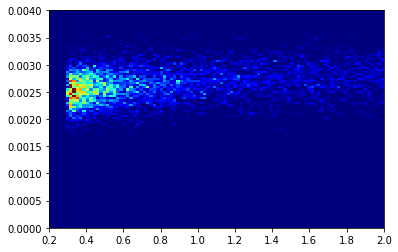

In [11]:
plt.hist2d(p_ges, signals[2]["ITS"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0, 0.004]])
plt.plot()

In [12]:
df_list=[]
for i, val in enumerate(masses):
    df = pd.DataFrame.from_dict(signals[i])
    df['p'] = pd.Series(p_ges, index=df.index)
    df['particle'] = pd.Series(i, index=df.index)
    df_list.append(df)


In [13]:
df_list[3].head()

,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle
0,0.001648,0.886889,1.219541,0.997935,1.203593,1.118583,9.589579,3
1,0.001503,0.833760,0.995753,1.092827,1.008888,0.805905,2.987579,3
2,0.001474,1.042847,0.977145,1.027516,0.903656,1.062048,4.698851,3
3,0.001735,0.906589,0.951312,1.054473,0.969149,0.804831,2.916813,3
4,0.001773,0.825912,0.975749,0.983869,1.174980,0.873440,5.522709,3


In [14]:
df_all = pd.concat([df_list[0],df_list[2],df_list[3],df_list[4]], ignore_index=True)

In [15]:
len(df_all)

40000

[]

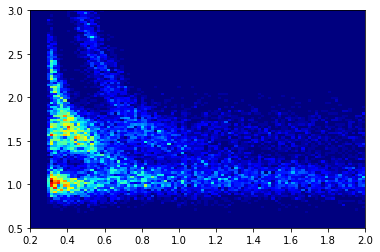

In [16]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.plot()

In [17]:
train, test =train_test_split(df_all, test_size=0.5)
test.head()

,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle
15850,0.003037,1.179649,1.356606,1.358242,1.542979,1.489969,0.913884,2
33380,0.001502,1.011873,1.054118,1.098580,1.127731,1.223613,1.073067,4
14953,0.002461,1.053820,1.633676,1.618784,1.838253,1.772187,3.174213,2
24351,0.001590,0.909947,1.194989,1.107401,1.104609,1.223243,8.557716,3
16608,0.002877,0.949310,1.665274,1.652772,1.547522,1.564844,2.202538,2


In [18]:
scaler = StandardScaler()
scaler.fit(train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]])
#out = scaler.transform(train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [19]:
model = Sequential()
model.add(Dense(units=64, activation='selu', input_dim=6))
model.add(Dense(units=64, activation='selu'))
model.add(Dense(units=64, activation='selu'))
model.add(Dense(units=2, activation='selu'))
model.add(Dense(units=64, activation='selu'))
model.add(Dense(units=64, activation='selu'))
model.add(Dense(units=64, activation='selu'))
model.add(Dense(units=6, activation='linear'))
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
__________

In [20]:
train_data = train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
test_data = test[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
model.fit(scaler.transform(train_data), scaler.transform(train_data), epochs=5, batch_size=32, 
          validation_data=[scaler.transform(test_data),scaler.transform(test_data)])

Train on 20000 samples, validate on 20000 samples
Epoch 1/5
20000/20000 [==============================] - 5s 253us/step - loss: 0.0532 - mean_squared_error: 0.0532 - val_loss: 0.0328 - val_mean_squared_error: 0.0328
Epoch 2/5
20000/20000 [==============================] - 4s 215us/step - loss: 0.0336 - mean_squared_error: 0.0336 - val_loss: 0.0313 - val_mean_squared_error: 0.0313
Epoch 3/5
20000/20000 [==============================] - 4s 210us/step - loss: 0.0322 - mean_squared_error: 0.0322 - val_loss: 0.0295 - val_mean_squared_error: 0.0295
Epoch 4/5
20000/20000 [==============================] - 4s 209us/step - loss: 0.0308 - mean_squared_error: 0.0308 - val_loss: 0.0297 - val_mean_squared_error: 0.0297
Epoch 5/5
20000/20000 [==============================] - 4s 211us/step - loss: 0.0311 - mean_squared_error: 0.0311 - val_loss: 0.0339 - val_mean_squared_error: 0.0339


2019-01-25 15:54:11.789559: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: FMA


In [21]:
out = scaler.inverse_transform(model.predict(scaler.transform(test_data)))

In [22]:
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
test_ri = test.reset_index()
df_test = pd.concat([test_ri,AE_predict], axis = 1)
df_test.head()

,index,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,ITS_ae,TOF_ae,TPCROC0_ae,TPCROC1_ae,TPCROC2_ae,TRD_ae
0,15850,0.003037,1.179649,1.356606,1.358242,1.542979,1.489969,0.913884,2,0.002791,1.178101,1.597620,1.570463,1.630367,1.567490
1,33380,0.001502,1.011873,1.054118,1.098580,1.127731,1.223613,1.073067,4,0.001896,1.006713,1.141795,1.136627,1.169071,1.147920
2,14953,0.002461,1.053820,1.633676,1.618784,1.838253,1.772187,3.174213,2,0.003076,1.064107,1.714535,1.707050,1.715291,1.691540
3,24351,0.001590,0.909947,1.194989,1.107401,1.104609,1.223243,8.557716,3,0.001920,0.909188,1.146228,1.151252,1.164520,1.162448
4,16608,0.002877,0.949310,1.665274,1.652772,1.547522,1.564844,2.202538,2,0.002980,0.954546,1.676665,1.669461,1.665140,1.638305


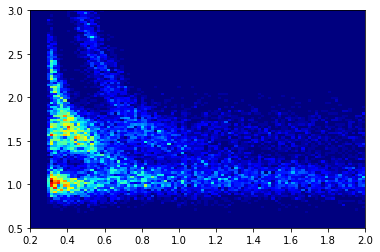

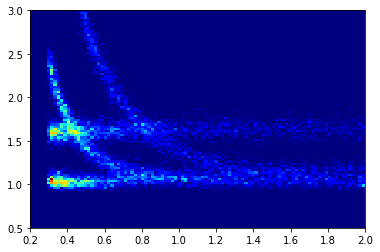

In [23]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

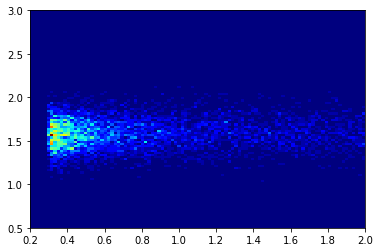

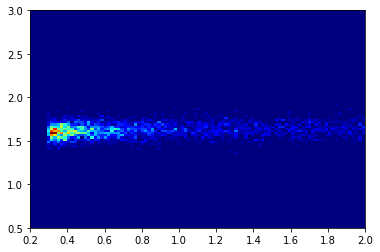

In [24]:
particle_id = 2
plt.hist2d(df_all.query("particle ==" +str(particle_id))["p"], df_all.query("particle == " +str(particle_id))["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test.query("particle ==" +str(particle_id))["p"], df_test.query("particle ==" +str(particle_id))["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

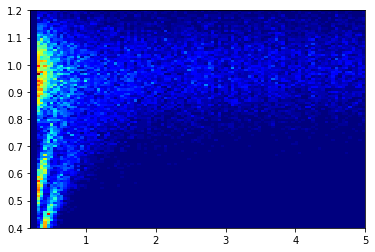

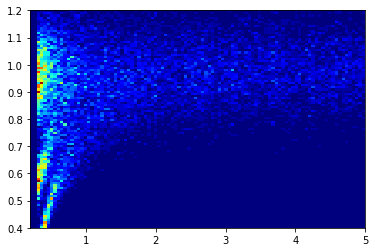

In [25]:
plt.hist2d(df_all["p"], df_all["TOF"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 5], [0.4, 1.2]])
plt.show()
plt.hist2d(df_test["p"], df_test["TOF_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 5], [0.4, 1.2]])
plt.show()

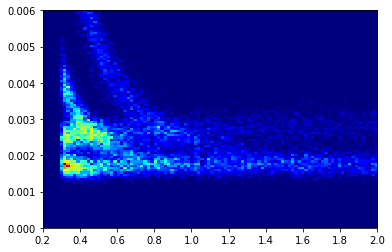

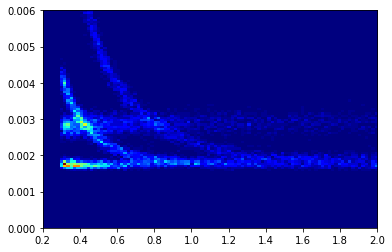

In [26]:
plt.hist2d(df_all["p"], df_all["ITS"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0, 0.006]])
plt.show()
plt.hist2d(df_test["p"], df_test["ITS_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0, 0.006]])
plt.show()

# Include zero entries

In [27]:
def flip(p):
    return 1 if np.random.random() < p else 0
N=40000
flips = []
for i in range(6):
    flips.append([flip(0.95) for i in xrange(N)])
ones = np.ones(N)
flip_dict = {"A" : flips[0], "B" : flips[1], "C" : flips[2], "D" : flips[3], 
             "E" : flips[4], "F" : flips[5], "G" : ones, "H" : ones}
flip_df =  pd.DataFrame.from_dict(flip_dict)
np.array(flip_df)

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 1., 1.],
       ...,
       [0., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [28]:
df_all_zeros = np.multiply(df_all,flip_df)
train_0, test_0, flipdftrain, flipdftest =train_test_split(df_all_zeros, flip_df, test_size=0.5)
train_data_0 = train_0[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
test_data_0 = test_0[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]

In [29]:
scaler_0 = StandardScaler()
scaler_0.fit(train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [30]:
model.fit(scaler_0.transform(train_data_0), scaler_0.transform(train_data_0), epochs=5, batch_size=32, 
          validation_data=[scaler_0.transform(test_data_0),scaler_0.transform(test_data_0)])

Train on 20000 samples, validate on 20000 samples
Epoch 1/5
20000/20000 [==============================] - 4s 210us/step - loss: 0.1694 - mean_squared_error: 0.1694 - val_loss: 0.1651 - val_mean_squared_error: 0.1651
Epoch 2/5
20000/20000 [==============================] - 4s 201us/step - loss: 0.1583 - mean_squared_error: 0.1583 - val_loss: 0.1643 - val_mean_squared_error: 0.1643
Epoch 3/5
20000/20000 [==============================] - 4s 200us/step - loss: 0.1550 - mean_squared_error: 0.1550 - val_loss: 0.1573 - val_mean_squared_error: 0.1573
Epoch 4/5
20000/20000 [==============================] - 4s 210us/step - loss: 0.1526 - mean_squared_error: 0.1526 - val_loss: 0.1610 - val_mean_squared_error: 0.1610
Epoch 5/5
20000/20000 [==============================] - 4s 206us/step - loss: 0.1495 - mean_squared_error: 0.1495 - val_loss: 0.1569 - val_mean_squared_error: 0.1569


In [31]:
out_0 = scaler_0.inverse_transform(model.predict(scaler_0.transform(test_data_0)))
AE_predict_0 = pd.DataFrame(out_0)
AE_predict_0.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
test_0 = test_0.reset_index()
df_test_0 = pd.concat([test_0,AE_predict_0], axis = 1)
df_test_0.head()

,index,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,ITS_ae,TOF_ae,TPCROC0_ae,TPCROC1_ae,TPCROC2_ae,TRD_ae
0,19283,0.002298,1.163103,1.880939,1.740229,1.735375,1.686556,0.428570,2.0,0.002693,1.112270,1.567619,1.578709,1.435131,1.555176
1,31070,0.001633,0.730604,1.063926,1.141520,1.049593,1.034511,0.842027,4.0,0.001880,0.741108,1.118425,1.072103,1.169542,1.083318
2,18565,0.002246,0.832305,1.496303,1.425562,1.564974,1.640909,0.532324,2.0,0.002617,0.860889,1.536917,1.564122,1.616377,1.433143
3,28059,0.008407,0.335917,0.000000,5.290347,5.227470,4.119982,0.356099,3.0,0.006679,0.355000,3.597812,4.009200,3.998581,4.327829
4,21551,0.001676,0.000000,1.137237,1.243751,1.227835,0.946221,4.339535,3.0,0.002101,-0.002605,1.264366,1.174384,1.195120,1.179151


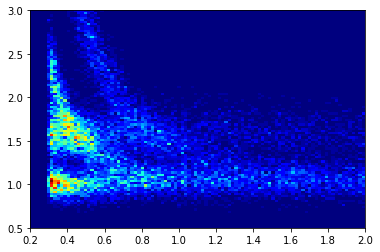

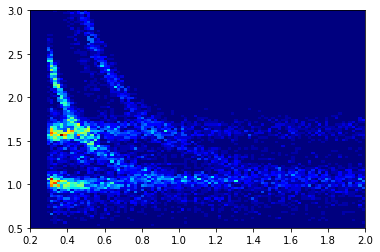

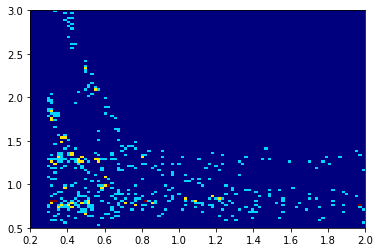

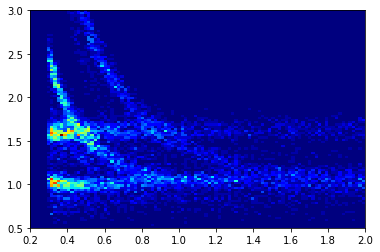

In [32]:
plt.hist2d(df_all_zeros["p"], df_all_zeros["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test_0["p"], df_test_0["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test_0.query("TPCROC1 == 0")["p"], df_test_0.query("TPCROC1 == 0")["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test_0.query("TPCROC1 > 0")["p"], df_test_0.query("TPCROC1 > 0")["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

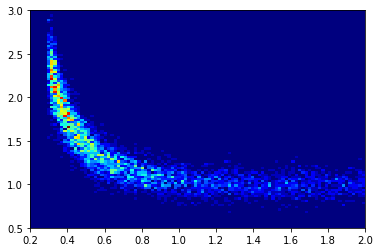

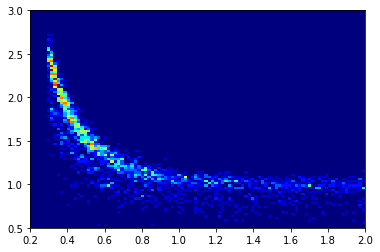

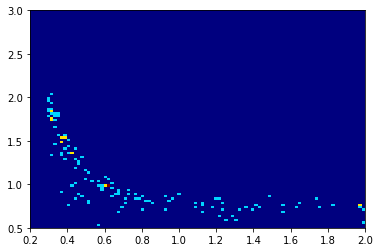

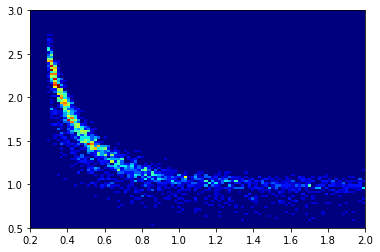

In [33]:
particle_id = 4
plt.hist2d(df_all_zeros.query("particle ==" +str(particle_id))["p"], df_all_zeros.query("particle == " +str(particle_id))["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test_0.query("particle ==" +str(particle_id))["p"], df_test_0.query("particle ==" +str(particle_id))["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test_0.query("particle ==" +str(particle_id)+"and TPCROC1==0")["p"], 
           df_test_0.query("particle ==" +str(particle_id)+"and TPCROC1==0")["TPCROC1_ae"], bins=(100, 100), 
           cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test_0.query("particle ==" +str(particle_id)+"and TPCROC1>0")["p"], 
           df_test_0.query("particle ==" +str(particle_id)+"and TPCROC1>0")["TPCROC1_ae"], bins=(100, 100), 
           cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# Labeled Zero Entries
in without entry, trained on data with entries

In [34]:
train_l0 = np.multiply(train, flip_df.sample(n=20000))
test_l0 = np.multiply(test, flip_df.sample(n=20000))
train_data_l0 = train_l0[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
test_data_l0 = test_l0[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]

In [35]:
scaler_l0in = StandardScaler()
scaler_l0out = StandardScaler()
scaler_l0in.fit(train_data_l0)
scaler_l0out.fit(train_data)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [36]:

model.fit(scaler_l0in.transform(train_data_l0), scaler_l0out.transform(train_data), epochs=5, batch_size=32, 
          validation_data=[scaler_l0in.transform(test_data_l0),scaler_l0out.transform(test_data)])

Train on 20000 samples, validate on 20000 samples
Epoch 1/5
20000/20000 [==============================] - 4s 210us/step - loss: 0.0593 - mean_squared_error: 0.0593 - val_loss: 0.0385 - val_mean_squared_error: 0.0385
Epoch 2/5
20000/20000 [==============================] - 4s 213us/step - loss: 0.0411 - mean_squared_error: 0.0411 - val_loss: 0.0365 - val_mean_squared_error: 0.0365
Epoch 3/5
20000/20000 [==============================] - 4s 214us/step - loss: 0.0383 - mean_squared_error: 0.0383 - val_loss: 0.0354 - val_mean_squared_error: 0.0354
Epoch 4/5
20000/20000 [==============================] - 4s 210us/step - loss: 0.0376 - mean_squared_error: 0.0376 - val_loss: 0.0362 - val_mean_squared_error: 0.0362
Epoch 5/5
20000/20000 [==============================] - 4s 210us/step - loss: 0.0373 - mean_squared_error: 0.0373 - val_loss: 0.0366 - val_mean_squared_error: 0.0366


In [37]:
out_l0 = scaler_l0in.inverse_transform(model.predict(scaler_l0in.transform(test_data_l0)))
AE_predict_l0 = pd.DataFrame(out_l0)
AE_predict_l0.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
test_l0 = test_l0.reset_index()
df_test_l0 = pd.concat([test_l0,AE_predict_l0], axis = 1)
df_test_l0.head()

,index,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,ITS_ae,TOF_ae,TPCROC0_ae,TPCROC1_ae,TPCROC2_ae,TRD_ae
0,15850,0.003037,1.179649,1.356606,1.358242,1.542979,1.489969,0.913884,2.0,0.002551,1.222731,1.468359,1.464037,1.525195,1.493748
1,33380,0.001502,1.011873,1.054118,1.098580,1.127731,1.223613,1.073067,4.0,0.001674,0.995197,0.983392,1.026906,1.024412,1.006894
2,14953,0.002461,1.053820,1.633676,1.618784,1.838253,1.772187,3.174213,2.0,0.002752,1.058433,1.547757,1.544984,1.604844,1.567116
3,24351,0.001590,0.909947,1.194989,1.107401,1.104609,1.223243,8.557716,3.0,0.001699,0.870993,0.997050,1.039859,1.044249,1.016831
4,16608,0.002877,0.949310,1.665274,1.652772,1.547522,1.564844,2.202538,2.0,0.002739,0.932610,1.547055,1.544266,1.608558,1.555369


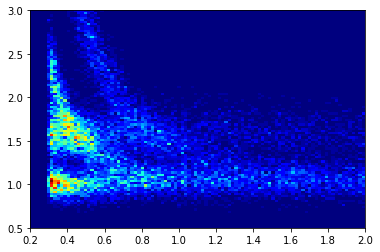

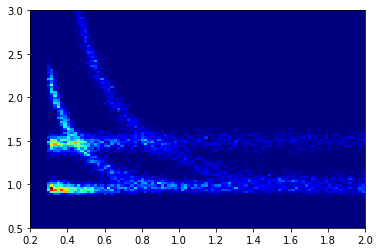

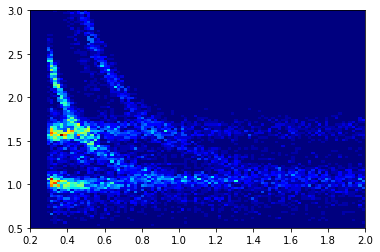

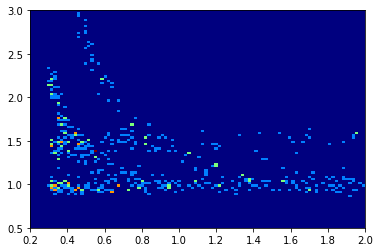

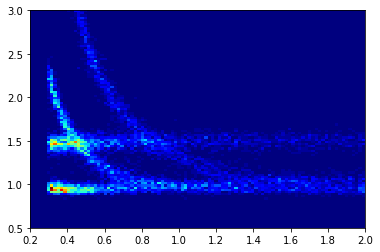

In [38]:
plt.hist2d(df_all_zeros["p"], df_all_zeros["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test_l0["p"], df_test_l0["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test_0["p"], df_test_0["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test_l0.query("TPCROC1 == 0")["p"], df_test_l0.query("TPCROC1 == 0")["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test_l0.query("TPCROC1 > 0")["p"], df_test_l0.query("TPCROC1 > 0")["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# Loss disregarding zero entries

In [39]:
zerofinder = pd.DataFrame(scaler_0.transform(train_data_0))
zerofinder.columns = ["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]
mins = []
for el in zerofinder.columns:
    minimum = np.min(np.array(zerofinder[[el]]))
    mins.append(minimum)
    print(minimum)

-1.765705864037811
-4.500022559214135
-1.8949964561373962
-1.9044197567363077
-1.9027073527530796
-1.8996667117012962


In [40]:
def loss_nozeros(y_true, y_pred):
    mins_tensor = tf.convert_to_tensor(mins)
    mins_tensor_corrdim = tf.ones([tf.shape(y_true)[0]])*mins_tensor
    greater = tf.greater(y_true,mins_tensor_corrdim)
    x = tf.where(greater, K.mean(K.square(y_true-y_pred)))
    return x

In [41]:
#model.compile(loss=loss_nozeros,
#              optimizer='adam')
#model.fit(scaler_0.transform(train_data_0), scaler_0.transform(train_data_0), epochs=5, batch_size=32, 
#          validation_data=[scaler_0.transform(test_data_0),scaler_0.transform(test_data_0)])

# input transformation (two autoencoder iterations)

In [42]:
out_tr0 = scaler.inverse_transform(model.predict(scaler.transform(train_data_0)))
AE_predict_tr0 = pd.DataFrame(out_tr0)
AE_predict_tr0.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
train_0 = train_0.reset_index()
df_train_0 = pd.concat([train_0,AE_predict_0], axis = 1)
df_train_0.head()

,index,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,ITS_ae,TOF_ae,TPCROC0_ae,TPCROC1_ae,TPCROC2_ae,TRD_ae
0,17619,0.002895,0.833223,1.530867,1.565678,1.549574,1.205198,0.542611,2.0,0.002693,1.112270,1.567619,1.578709,1.435131,1.555176
1,3622,0.001530,1.047347,0.943540,0.990049,1.067066,0.975891,0.527457,0.0,0.001880,0.741108,1.118425,1.072103,1.169542,1.083318
2,756,0.002050,1.070506,0.000000,0.000000,0.000000,1.206116,4.777428,0.0,0.002617,0.860889,1.536917,1.564122,1.616377,1.433143
3,19426,0.002659,1.025786,1.650342,1.587314,1.273705,1.530428,2.150323,2.0,0.006679,0.355000,3.597812,4.009200,3.998581,4.327829
4,30412,0.001688,0.831577,1.074190,0.000000,1.269411,0.915956,7.883060,4.0,0.002101,-0.002605,1.264366,1.174384,1.195120,1.179151


In [43]:
ITS_1it = np.where(df_train_0.ITS==0, df_train_0.ITS_ae, df_train_0.ITS)
TOF_1it = np.where(df_train_0.TOF==0, df_train_0.TOF_ae, df_train_0.TOF)
TPCROC0_1it = np.where(df_train_0.TPCROC0==0, df_train_0.TPCROC0_ae, df_train_0.TPCROC0)
TPCROC1_1it = np.where(df_train_0.TPCROC1==0, df_train_0.TPCROC1_ae, df_train_0.TPCROC1)
TPCROC2_1it = np.where(df_train_0.TPCROC2==0, df_train_0.TPCROC2_ae, df_train_0.TPCROC2)
TRD_1it = np.where(df_train_0.TRD==0, df_train_0.TRD_ae, df_train_0.TRD)

In [44]:
train_1it = pd.DataFrame(np.array([ITS_1it,TOF_1it,TPCROC0_1it,TPCROC1_1it,TPCROC2_1it,TRD_1it]).T)
train_1it.columns=["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]

In [45]:
train_1it.head()

,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD
0,0.002895,0.833223,1.530867,1.565678,1.549574,1.205198
1,0.001530,1.047347,0.943540,0.990049,1.067066,0.975891
2,0.002050,1.070506,1.536917,1.564122,1.616377,1.206116
3,0.002659,1.025786,1.650342,1.587314,1.273705,1.530428
4,0.001688,0.831577,1.074190,1.174384,1.269411,0.915956


In [46]:
out_tt0 = scaler.inverse_transform(model.predict(scaler.transform(test_data_0)))
AE_predict_tt0 = pd.DataFrame(out_tt0)
AE_predict_tt0.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
test_0 = test_0.reset_index()
df_test_0 = pd.concat([test_0,AE_predict_0], axis = 1)
df_test_0 = df_test_0.drop("index",axis = 1)
df_test_0 = df_test_0.drop("level_0",axis = 1)
df_test_0.head()
ITS_1it_tt = np.where(df_test_0.ITS==0, df_test_0.ITS_ae, df_test_0.ITS)
TOF_1it_tt = np.where(df_test_0.TOF==0, df_test_0.TOF_ae, df_test_0.TOF)
TPCROC0_1it_tt = np.where(df_test_0.TPCROC0==0, df_test_0.TPCROC0_ae, df_test_0.TPCROC0)
TPCROC1_1it_tt = np.where(df_test_0.TPCROC1==0, df_test_0.TPCROC1_ae, df_test_0.TPCROC1)
TPCROC2_1it_tt = np.where(df_test_0.TPCROC2==0, df_test_0.TPCROC2_ae, df_test_0.TPCROC2)
TRD_1it_tt = np.where(df_test_0.TRD==0, df_test_0.TRD_ae, df_test_0.TRD)

In [47]:
test_1it = pd.DataFrame(np.array([ITS_1it_tt,TOF_1it_tt,TPCROC0_1it_tt,TPCROC1_1it_tt,TPCROC2_1it_tt,TRD_1it_tt]).T)
test_1it.columns=["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]

In [48]:
df_test_0.head()

,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,ITS_ae,TOF_ae,TPCROC0_ae,TPCROC1_ae,TPCROC2_ae,TRD_ae
0,0.002298,1.163103,1.880939,1.740229,1.735375,1.686556,0.428570,2.0,0.002693,1.112270,1.567619,1.578709,1.435131,1.555176
1,0.001633,0.730604,1.063926,1.141520,1.049593,1.034511,0.842027,4.0,0.001880,0.741108,1.118425,1.072103,1.169542,1.083318
2,0.002246,0.832305,1.496303,1.425562,1.564974,1.640909,0.532324,2.0,0.002617,0.860889,1.536917,1.564122,1.616377,1.433143
3,0.008407,0.335917,0.000000,5.290347,5.227470,4.119982,0.356099,3.0,0.006679,0.355000,3.597812,4.009200,3.998581,4.327829
4,0.001676,0.000000,1.137237,1.243751,1.227835,0.946221,4.339535,3.0,0.002101,-0.002605,1.264366,1.174384,1.195120,1.179151


In [49]:
scaler_1it = StandardScaler()
scaler_1it.fit(train_1it[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]])
model.fit(scaler_1it.transform(train_1it[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]), 
          scaler_1it.transform(train_1it[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]), epochs=5, batch_size=32, 
          validation_data=[scaler_1it.transform(test_1it[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]),
                           scaler_1it.transform(test_1it[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]])])

Train on 20000 samples, validate on 20000 samples
Epoch 1/5
20000/20000 [==============================] - 4s 215us/step - loss: 0.0908 - mean_squared_error: 0.0908 - val_loss: 0.0615 - val_mean_squared_error: 0.0615
Epoch 2/5
20000/20000 [==============================] - 4s 205us/step - loss: 0.0846 - mean_squared_error: 0.0846 - val_loss: 0.0581 - val_mean_squared_error: 0.0581
Epoch 3/5
20000/20000 [==============================] - 4s 212us/step - loss: 0.0830 - mean_squared_error: 0.0830 - val_loss: 0.0581 - val_mean_squared_error: 0.0581
Epoch 4/5
20000/20000 [==============================] - 4s 208us/step - loss: 0.0833 - mean_squared_error: 0.0833 - val_loss: 0.0580 - val_mean_squared_error: 0.0580
Epoch 5/5
20000/20000 [==============================] - 4s 214us/step - loss: 0.0820 - mean_squared_error: 0.0820 - val_loss: 0.0581 - val_mean_squared_error: 0.0581


In [59]:
out_1it = scaler_1it.inverse_transform(model.predict(scaler_1it.transform(test_1it[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]])))
AE_predict_1it = pd.DataFrame(out_1it)
AE_predict_1it.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
#test_1it = test_1it.reset_index()
df_test_1it = pd.concat([test_1it,AE_predict_1it], axis = 1)
df_test_1it.head()
df_test_1it['p'] = pd.Series(df_test_0["p"], index=df.index)
df_test_1it['particle'] = pd.Series(df_test_0["particle"], index=df.index)

In [54]:
df_test_1it = df_test_1it.drop("index",axis=1)

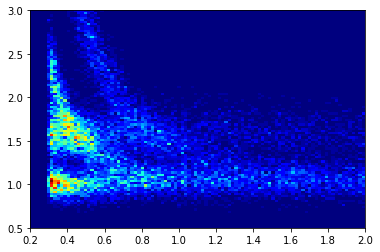

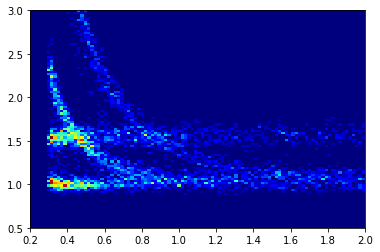

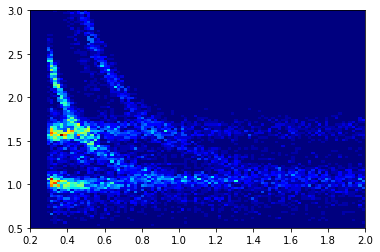

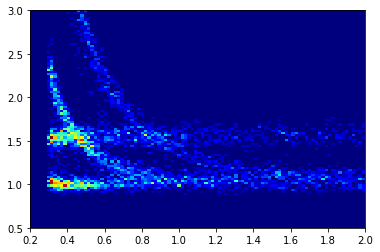

In [58]:
plt.hist2d(df_all_zeros["p"], df_all_zeros["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test_1it["p"], df_test_1it["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test_0["p"], df_test_0["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test_1it.query("TPCROC1 > 0")["p"], df_test_1it.query("TPCROC1 > 0")["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

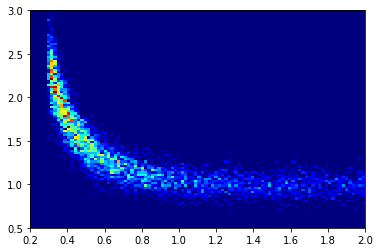

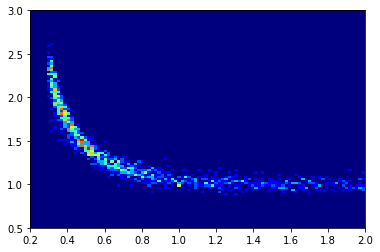

In [65]:
particle_id = 4
plt.hist2d(df_all.query("particle ==" +str(particle_id))["p"], df_all.query("particle == " +str(particle_id))["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test_1it.query("particle ==" +str(particle_id))["p"], df_test_1it.query("particle ==" +str(particle_id))["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# plot latent space 

In [71]:
f = K.function([model.layers[0].input, K.learning_phase()], [model.layers[3].output])

In [72]:
lat_space = f([pd.DataFrame(test_1it[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]),1])

In [77]:
np.array(lat_space)[-1].T[0].shape

(20000,)

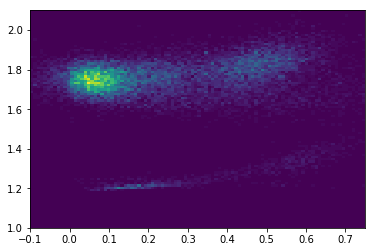

In [91]:
plt.hist2d(np.array(lat_space)[-1].T[0],np.array(lat_space)[-1].T[1], range=[[-0.1,0.75],[1,2.1]], bins=100)
plt.show()